# Monthly means of surface relative humidity

## 1 Overview

- Notebook intended to calculate monthly means of relative humidity at surface based on ERA-INTERIM datasets of temperature and dew point temperature both at surface (2 m above the ground).

- **References**:

    - [ERA datasets: near-surface humidity](https://confluence.ecmwf.int/display/CKB/ERA+datasets%3A+near-surface+humidity).

    - [Calculate Temperature, Dewpoint, or Relative Humidity](http://andrew.rsmas.miami.edu/bmcnoldy/Humidity.html).

- Based on Clausius-Clayperon equation:

    $$ 
    e_s(T) = 6.1094 \exp{\left( \frac{17.625 T}{T + 243.04} \right)}
    $$
    where $T$ is temperature in degree Celsius, you can calculate relative humidity $RH$ as the following:

    $$
    RH = \frac{e_s(T_d)}{e_s(T)} 100 \%
    $$
    where $T_d$ is the dew point temperature.

## 2 Initial setup

In [1]:
# Load packages.
import sys
import glob
import datetime
import calendar
import progressbar
import os

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

%matplotlib inline

In [2]:
# My repository.
repository = "/home/alex/Dropbox/repositories/doctoral_thesis/libraries/"

In [3]:
# Include once my repository in the path for searching libraries.
if repository not in sys.path:
    sys.path.append(repository)
    
# Import my libraries.
import cdlearn

In [4]:
# Folder with ERA-INTERIM data.
DATA_FOLDER = "/media/alex/ALEXDATA/data_sets/ERA_INTERIM/"

## 3 Read data

In [5]:
# Data folders.
DATA_FOLDER1 = DATA_FOLDER + "surface_temperature_mmeans/"
DATA_FOLDER2 = DATA_FOLDER + "surface_dew_point_temperature_mmeans/"

# Absolute files paths. Only grib extensions.
FILES1 = sorted(glob.glob(DATA_FOLDER1 + "*grb"))
FILES2 = sorted(glob.glob(DATA_FOLDER2 + "*grb"))

# Load data (lazy).
DATASET1 = xr.open_mfdataset(FILES1, engine="cfgrib")
DATASET2 = xr.open_mfdataset(FILES2, engine="cfgrib")

# Xarray DataArray objects.
T2M = DATASET1.t2m
D2M = DATASET2.d2m

# Just for precaution.
T2M, D2M = xr.align(T2M, D2M)

## 4 Retrieve relative humidity

In [6]:
def relative_humidity_retrieval(T, TD):
    """
    Relative humidity calculation.
    
    The inputs are xarray DataArrays for surface temperature (T) and for
    surface dew point temperature (TD). This function uses Clausius-Clayperon
    equation in the following form:
    
    es(T) = 6.1094 * exp((17.625 * T) / (T + 243.04))
    
    for calculating surface relative humidity as:
    
    RH = es(Td) / es(T) * 100%
    
    The output is also a xarray DataArray class.
    """
    
    # Put the in the same spatio-temporal grid.
    T, TD = xr.align(T, TD)
    
    es_T = 6.1094 * np.exp((17.625 * T) / (T + 243.04))
    es_Td = 6.1094 * np.exp((17.625 * TD) / (TD + 243.04))
    
    return es_Td / es_T * 100

In [7]:
# Surface relative humidity in percentage (as xarray DataArray class).
RELHUM = relative_humidity_retrieval(T2M, D2M)

# Let's convert from DataArray to Dataset xarray object.
RELHUM = RELHUM.to_dataset(name="relhum")

# Add some attributes.
RELHUM.attrs["Calculation"] = "Made by Alex Araujo at " + \
                               datetime.datetime.now().strftime("%Y-%m-%d")
RELHUM.attrs["Origin"] = "ERA-INTERIM data sets for surface temperature and " + \
                         "surface dew point temperatures (at 2 m above the ground)"
RELHUM.relhum.attrs["units"] = "%"

## 5 Exporting relative humidity data as netcdf files

In [8]:
# Pandas date times.
dates = pd.to_datetime(RELHUM.time.values)

# Range of dates. 
years = dates.year.unique()
number_of_iterations = years.size 

# Where data will be put.
data_path = DATA_FOLDER + "surface_relative_humidity_mmeans/"

# Root for file name.
root = "relhum_mmeans_"

# Loop over each month in each year.
with progressbar.ProgressBar(max_value=number_of_iterations) as p:
    index = 0
    for year in years:
    
        # Data file.
        file_path = data_path + root + "{0:04d}.nc".format(year)
    
        # Continue only if data file does not exist yet.
        if not os.path.isfile(file_path):
    
            # Select data corresponding to this date.
            DATASET = RELHUM.sel(time=str(year))
            
            # Export selected data as a netcdf file.
            DATASET.to_netcdf(file_path)
            
        index += 1
        p.update(index)

100% (40 of 40) |########################| Elapsed Time: 0:00:09 Time:  0:00:09


## 6 Read surface relative humidity

In [9]:
# Data folder.
DATA_FOLDER3 = DATA_FOLDER + "surface_relative_humidity_mmeans/"

# Absolute files paths. Only netcdf extensions.
FILES3 = sorted(glob.glob(DATA_FOLDER3 + "*nc"))

In [10]:
# %%time

# Read data as xarray Dataset class.
RELHUM = xr.open_mfdataset(FILES3)
RELHUM

<xarray.Dataset>
Dimensions:     (latitude: 241, longitude: 480, time: 480)
Coordinates:
    number      int64 0
    step        timedelta64[ns] 00:00:00
    surface     int64 0
  * latitude    (latitude) float64 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
  * longitude   (longitude) float64 0.0 0.75 1.5 2.25 ... 357.8 358.5 359.2
  * time        (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2018-12-01
    valid_time  (time) datetime64[ns] dask.array<shape=(480,), chunksize=(12,)>
Data variables:
    relhum      (time, latitude, longitude) float32 dask.array<shape=(480, 241, 480), chunksize=(12, 241, 480)>
Attributes:
    Calculation:  Made by Alex Araujo at 2019-06-16
    Origin:       ERA-INTERIM data sets for surface temperature and surface d...

## 7 Monthly means

In [11]:
# Group data by month and then calculate the mean.
RELHUM_mm = RELHUM.relhum.groupby("time.month").mean("time")

In [12]:
RELHUM_mm

<xarray.DataArray 'relhum' (month: 12, latitude: 241, longitude: 480)>
dask.array<shape=(12, 241, 480), dtype=float32, chunksize=(1, 241, 480)>
Coordinates:
    number     int64 0
    step       timedelta64[ns] 00:00:00
    surface    int64 0
  * latitude   (latitude) float64 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
  * longitude  (longitude) float64 0.0 0.75 1.5 2.25 ... 357.0 357.8 358.5 359.2
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

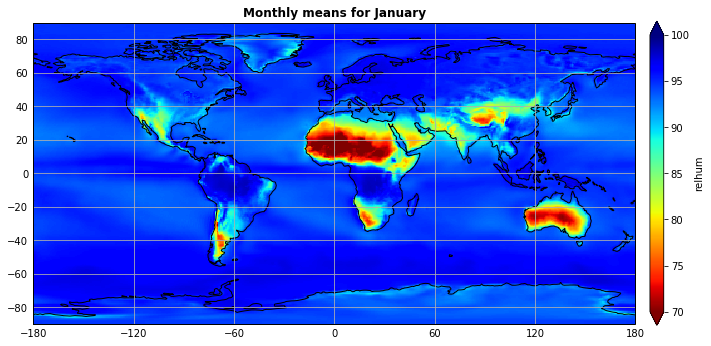

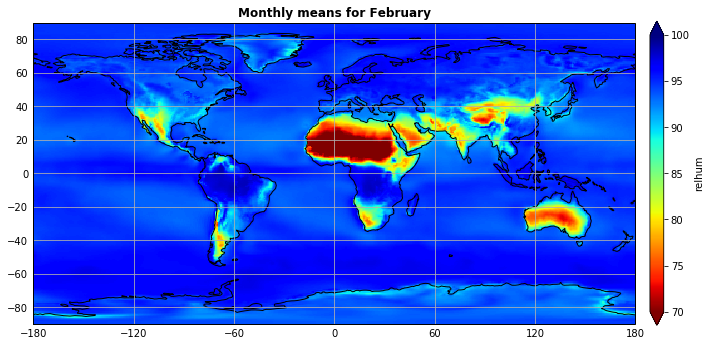

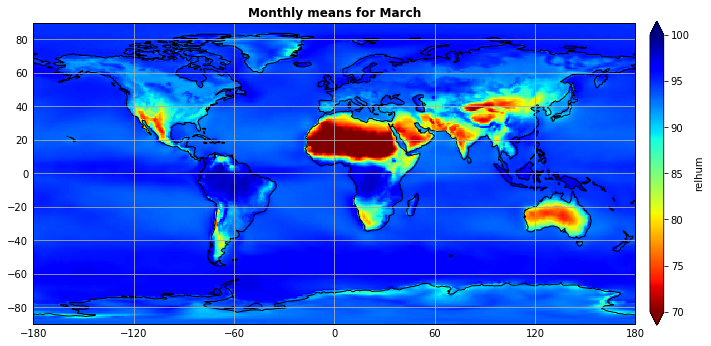

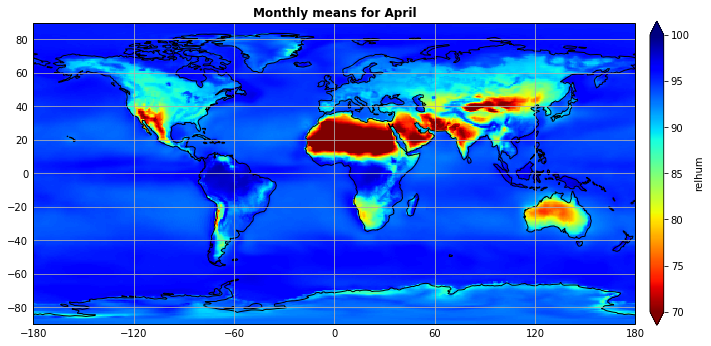

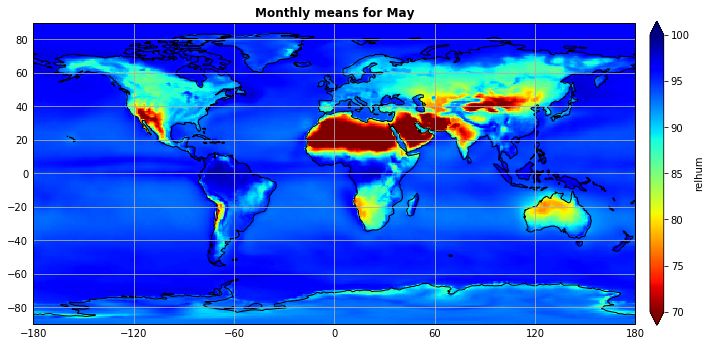

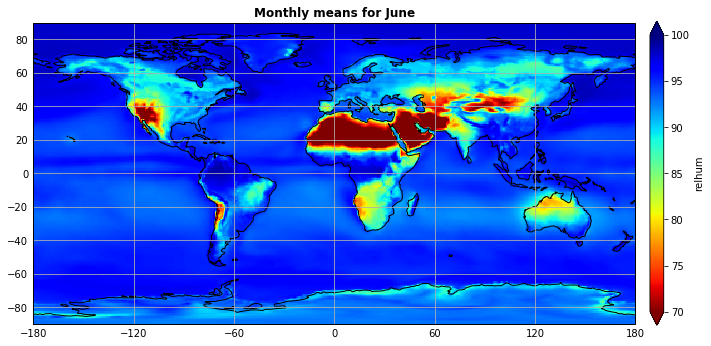

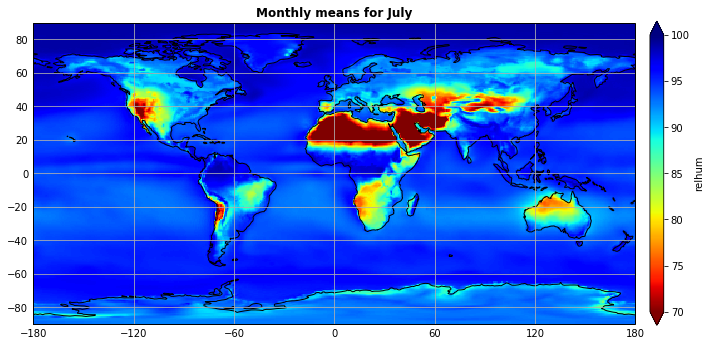

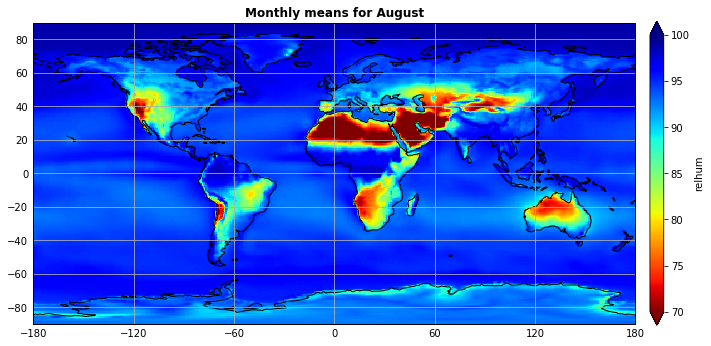

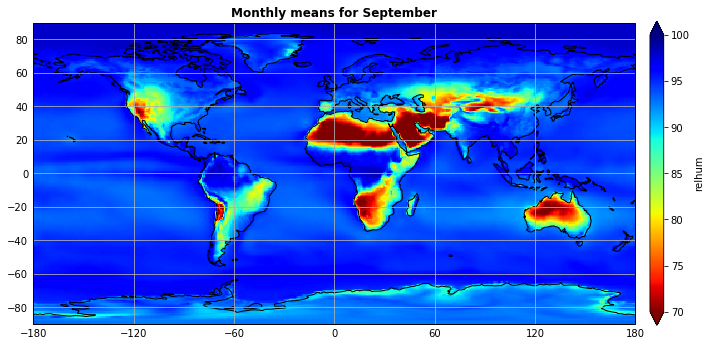

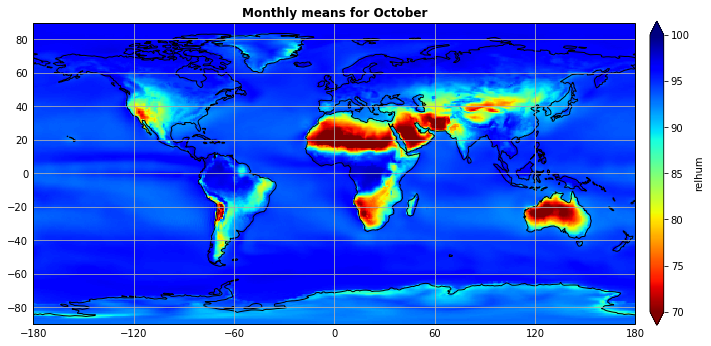

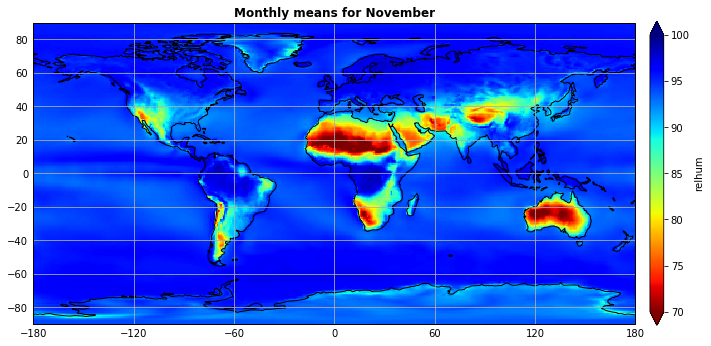

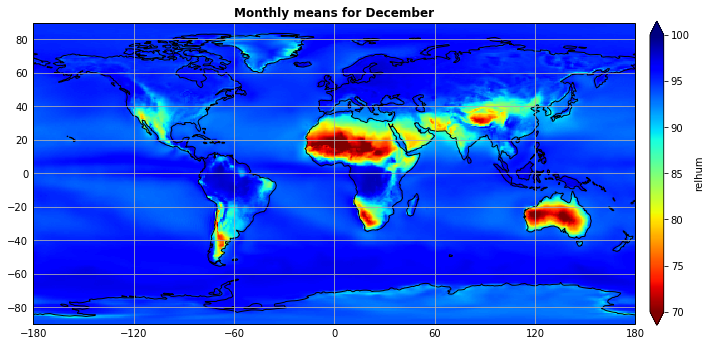

In [13]:
# Plot monthly means.
for month in range(1, 13):
    
    # Make map.
    fig = plt.figure(figsize=(13, 7))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.coastlines()
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False
    map = RELHUM_mm.sel(month=month).plot(ax=ax, 
                                          vmin=70, vmax=100,
                                          cmap=plt.cm.jet_r, 
                                          cbar_kwargs={"shrink": 0.80,
                                                       "pad": 0.020,
                                                       "extend": "both"})
    ax.set_title("Monthly means for " + calendar.month_name[month], weight="bold");

## 8 Time series

In [14]:
# Select a pixel around Amazonia.
lon = 120; lat = -5

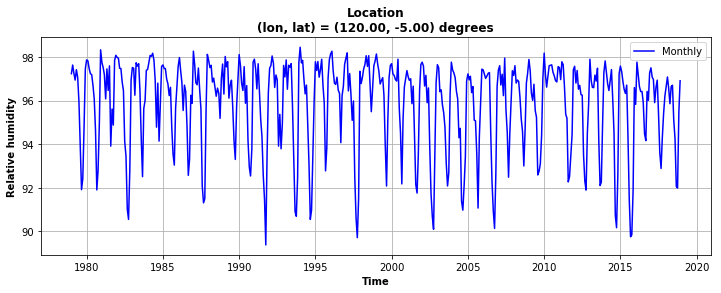

In [15]:
# Retrieve monthly time series.
TS = RELHUM.relhum.sel(longitude=lon, latitude=lat, method="nearest")

# Plot this time series.
plt.figure(figsize=(12, 4))
plt.plot(TS.time, TS.values, "-b", label="Monthly")
plt.xlabel("Time", weight="bold")
plt.ylabel("Relative humidity", weight="bold")
plt.title("Location\n(lon, lat) = (%.2f, %.2f) degrees" %(lon, lat), weight="bold")
plt.grid()
plt.legend();